In [1]:
from typing import List

import pytorch_lightning as pl
import torch
import wandb
import uuid
from torch import nn

from datamodule import SpritesDataModule
from simple_vae import ConvVAE


In [2]:
SEED = 42

In [3]:
dm = SpritesDataModule(
        dir="dsprites-dataset",
        batch_size=128,
        val_split=0.9,
        transforms=None,
        seed=SEED,
    )

dm.setup("fit")

In [4]:
model_checkpoint = "ConvVAE_116c521f-6b37-43a6-b409-cb69e0eaf875-epoch=40-val_loss=2854.24.ckpt"

In [5]:
model = ConvVAE.load_from_checkpoint(f"checkpoints\{model_checkpoint}")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/m0j0bqc/Desktop/DGM_VAE_assignment/checkpoints\\ConvVAE_116c521f-6b37-43a6-b409-cb69e0eaf875-epoch=40-val_loss=2854.24.ckpt'

In [ ]:
model.eval()

In [9]:
z = torch.randn(100, model.hparams.latent_dim, device=model.device)

In [10]:
x = model.decoder_input(z)
x = model.unflatten(x)
x = model.decoder(x)
samples = model.final_layer(x)

In [12]:
import matplotlib.pyplot as plt

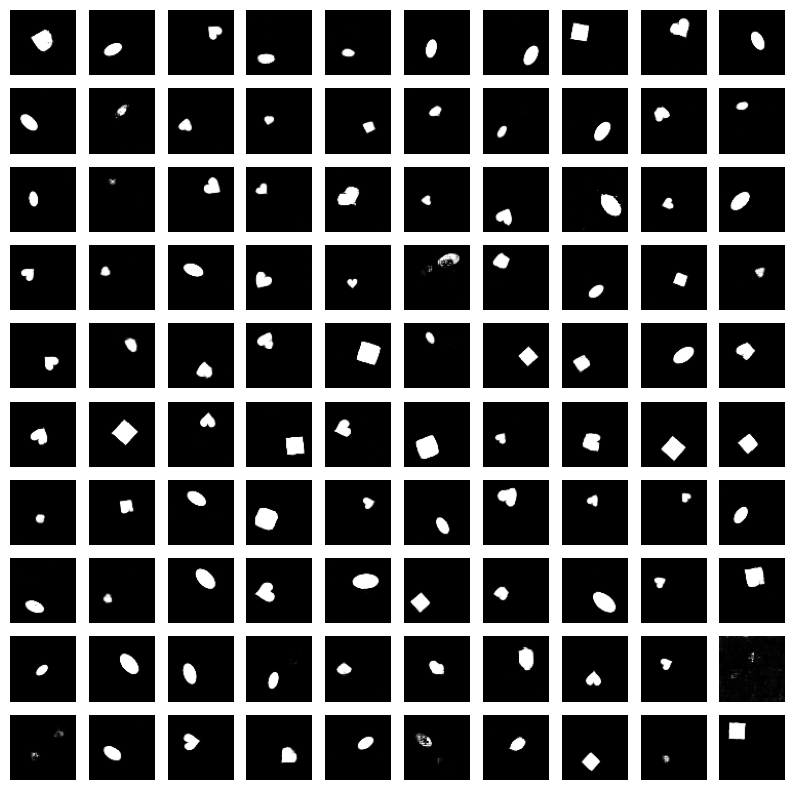

In [13]:
# Plot 100 random samples of the generated images in a 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].detach().numpy().squeeze(), cmap="gray")
    ax.axis("off")
plt.show()


In [6]:
import numpy as np
import os
from rich.progress import track
import matplotlib.pyplot as plt
from PIL import Image
# import cv2

In [7]:
model_checkpoints = [
    "ConvVAE_68ac55b0-7b6e-4dee-adf8-4c90208ead16-epoch=45-val_loss=2940.56.ckpt", 
    "ConvVAE_116c521f-6b37-43a6-b409-cb69e0eaf875-epoch=40-val_loss=2854.24.ckpt", 
    "ConvVAE_c9e25e0e-9a1a-4800-9da6-e159a66244aa-epoch=49-val_loss=3758.52.ckpt"
    ]

In [6]:
# def generate_reconstruction(model_checkpoint):
#     model = ConvVAE.load_from_checkpoint(f"checkpoints\{model_checkpoint}").to("cuda")
#     model.eval()
#     # generate reconstructions of all images in validation set
#     reconstructions = []
#     for batch in dm.val_dataloader():
#         x, _ = batch
#         x = x.to(model.device)
#         reconstructions.append(model(x)[0].detach().cpu())
#     reconstructions = torch.cat(reconstructions)
#     # save in numpy npz format in the output folder
#     np.savez_compressed(f"outputs/{model_checkpoint}_reconstructions.npz", reconstructions=reconstructions)


In [54]:
# generate reconstructions of all images in validation set and save in a folder in the outputs folder
def generate_reconstructions(model_checkpoint: str):
    model = ConvVAE.load_from_checkpoint(f"checkpoints\{model_checkpoint}").to("cuda")
    model.eval()
    reconstructions = []
    for batch in track(dm.val_dataloader(), total=len(dm.val_dataloader()), description=f"Generating reconstructions for {model_checkpoint}"):
        x, _ = batch
        x = x.to(model.device)
        reconstructions.append(model(x)[0].detach().cpu())
    # save reconstructions as separate images in output folder
    reconstructions = torch.cat(reconstructions)
    print(reconstructions[0].shape)
    os.makedirs(f"outputs/{model_checkpoint}", exist_ok=True)
    for i, reconstruction in track(enumerate(reconstructions), total=len(reconstructions), description=f"Saving reconstructions for {model_checkpoint}"):
        plt.imsave(f"outputs/{model_checkpoint}/{i}.png", reconstruction.detach().numpy().squeeze(), cmap="gray")
        # img = cv2.cvtColor(reconstruction.detach().numpy(),cv2.COLOR_GRAY2RGB)
        # cv2.imwrite(f"outputs/{model_checkpoint}/{i}.png", img)


In [55]:
for model_checkpoint in model_checkpoints:
    generate_reconstructions(model_checkpoint)

torch.Size([1, 64, 64])


torch.Size([1, 64, 64])


torch.Size([1, 64, 64])


In [59]:
#save all val images as separate images in output folder
val = []
for batch in dm.val_dataloader():
    x, _ = batch
    val.append(x)
val = torch.cat(val)
os.makedirs(f"outputs/val", exist_ok=True)
for i, reconstruction in track(enumerate(val), total=len(val), description=f"Saving Val"):
    plt.imsave(f"outputs/val/{i}.png", reconstruction.detach().numpy().squeeze(), cmap="gray")
# np.savez_compressed(f"outputs/original_images.npz", original_images=val)

In [60]:
from pytorch_fid.fid_score import calculate_fid_given_paths

In [61]:
calculate_fid_given_paths(["outputs/val", "outputs/ConvVAE_c9e25e0e-9a1a-4800-9da6-e159a66244aa-epoch=49-val_loss=3758.52.ckpt"], 128, "cuda", 2048)

100%|██████████| 576/576 [04:28<00:00,  2.15it/s]


96.48476521858498

In [1]:
import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)
# generate two slightly overlapping image intensity distributions
imgs_dist1 = torch.randint(0, 200, (100, 3, 299, 299), dtype=torch.uint8)
imgs_dist2 = torch.randint(100, 255, (100, 3, 299, 299), dtype=torch.uint8)
fid.update(imgs_dist1, real=True)
fid.update(imgs_dist2, real=False)
fid.compute()

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

tensor(12.7202)

In [2]:
imgs_dist1.shape

torch.Size([100, 3, 299, 299])

In [3]:
imgs_dist2.shape

torch.Size([100, 3, 299, 299])

In [ ]:
fid = FrechetInceptionDistance(reset_real_features=False, normalize=True)

In [ ]:
# latent_decoded with shape 48, 1, 64, 64
# plot latent_decoded as a grid of 8x6 images with labels indicating latent dimension, original samples. etc
fig, axes = plt.subplots(8, 6, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(latent_decoded[i].detach().numpy().squeeze(), cmap="gray")
    ax.axis("off")
plt.show()


In [ ]:
#random integer from 0 to 9 using pytorch
torch.randint(0, 10, (1,))

## Disentanglement Metric

In [12]:
from rich.progress import track
import numpy as np

In [9]:
for batch in track(dm.val_dataloader(), total=len(dm.val_dataloader()), description=f"Generating reconstructions"):
    x, [latent_classes, latent_values] = batch
    break

Output()

In [20]:
class model:
    class hparams:
        latent_dim = 6
    @staticmethod
    def encoder(x):
        return x

In [13]:
idx = np.random.randint(0, model.hparams.latent_dim)

In [17]:
from collections import defaultdict

disentanglement_data = defaultdict(list)

In [21]:


# unique values in a tensor
for y in torch.unique(latent_classes[:, idx]):
    # select all samples with y for latent dimension of interest idx
    samples = latent_classes[latent_classes[:, idx] == y]
    # split mode_samples into 2 equal parts after shuffling using torch
    v1, v2 = torch.split(samples[torch.randperm(samples.shape[0])], samples.shape[0] // 2)
    # get latent vector for each half
    z1 = model.encode(v1)
    z2 = model.encode(v2)
    # calculate absolute difference between latent vectors
    z_diff = torch.mean(torch.abs(z1 - z2))
    # add to disentanglement data
    disentanglement_data[y.item()].append(z_diff.item())


AttributeError: type object 'model' has no attribute 'encode'

In [14]:
# select most common value for latent dimension of interest idx
y = torch.mode(latent_values[:, idx])[0]
# select all samples with mode value for latent dimension of interest idx
mode_samples = latent_values[latent_values[:, idx] == y]
# split mode_samples into 2 equal parts
v1, v2 = torch.split(mode_samples, mode_samples.shape[0] // 2, dim=0)
# get latent vector for each half
z1 = model.decode(v1)
z2 = model.decode(v2)
# calculate absolute difference between latent vectors
z_diff = torch.mean(torch.abs(z1 - z2))



tensor(1.1278, dtype=torch.float64)